In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
filename = 'cleaned_df.csv'

df = pd.read_csv(filename)

df = df.drop(columns='Unnamed: 0', axis=1)

df = df.rename(columns={'charges': 'label'})

#move label to the first position
first_column = df.pop('label') 
df.insert(0, 'label', first_column) 

print('Shape', df.shape)
df.head()

Shape (8932, 49)


,label,age,death,sex,hospdead,slos,d.time,num.co,edu,scoma,...,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig,ca_metastatic,ca_no,ca_yes,income_$11-$25k,income_$25-$50k,income_>$50k,income_under $11k,income_unknown
0,9715.0,62.84998,0,0,0,5,1740,0,11.000000,0.0,...,1,0,1,0,0,1,0,0,0,0
1,34496.0,60.33899,1,1,1,4,5,2,12.000000,44.0,...,0,0,0,1,0,1,0,0,0,0
2,41094.0,52.74698,1,1,0,17,47,2,12.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
3,3075.0,42.38498,1,1,0,4,133,2,11.000000,0.0,...,1,0,1,0,0,0,0,0,1,0
4,50127.0,79.88495,0,1,0,16,1740,1,11.744707,26.0,...,0,0,0,1,0,0,0,0,0,1


Figuring out what features to use for predicting in two steps:
1. Using correlation
2. Using Random Forest Classifier

In [3]:

# Calculate the correlation with 'label'
correlation_with_label = df.corrwith(df['label']).to_frame()
correlation_with_label.columns = ['Correlation with label']

# Drop the 'label' column from the correlation results
correlation_with_label = correlation_with_label.drop(labels=['label'])

# Sort the DataFrame by the 'Correlation with label' column in descending order
top_corr_features = correlation_with_label.sort_values(by='Correlation with label', ascending=False).head(15)

print(top_corr_features)


                           Correlation with label
slos                                     0.612165
hday                                     0.467400
avtisst                                  0.465429
dzgroup_ARF/MOSF w/Sepsis                0.333557
aps                                      0.323272
sps                                      0.309708
bili                                     0.196509
hospdead                                 0.187240
scoma                                    0.181983
hrt                                      0.141521
temp                                     0.134822
ca_no                                    0.114627
crea                                     0.112833
edu                                      0.107258
bun                                      0.085426


In [4]:
"""Using Random forest regressor"""

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Assuming df is your DataFrame and 'label' is your target variable
X = df.drop('label', axis=1)  # Features
y = df['label']               # Target

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to your data
rf_regressor.fit(X, y)

# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a Series for feature importances
rf_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

# Select the top 15 features
top_rf_features = rf_features.head(15)

# Print the feature importances
print("Top 15 features according to Random Forest Regressor:")
print(top_rf_features)


Top 15 features according to Random Forest Regressor:
slos       0.370875
hday       0.125928
avtisst    0.080983
sps        0.033811
age        0.032257
scoma      0.030417
bun        0.027259
d.time     0.027233
bili       0.022423
wblc       0.019036
alb        0.017909
aps        0.017518
urine      0.016806
ph         0.015829
hrt        0.014189
dtype: float64


In [5]:
#features mixed from two methods correlation check and random forest


rf_feature_list_regression = top_rf_features.index.tolist()
corr_feature_list_regression = top_corr_features.index.tolist()


combined_features_regression = list(set(rf_feature_list_regression) & set(corr_feature_list_regression))  # Intersection

alternative_features_regression = list(set(rf_feature_list_regression) | set(corr_feature_list_regression)) #union

print("Set of features for predicting: ", combined_features_regression)
print("Set with alternative features for improving model if needed: ", alternative_features_regression)

df = df[combined_features_regression + ['label'] ]
df.head()

Set of features for predicting:  ['bili', 'sps', 'hrt', 'avtisst', 'hday', 'aps', 'bun', 'slos', 'scoma']
Set with alternative features for improving model if needed:  ['bili', 'ca_no', 'temp', 'aps', 'edu', 'bun', 'slos', 'wblc', 'urine', 'd.time', 'hospdead', 'alb', 'sps', 'ph', 'crea', 'hrt', 'avtisst', 'dzgroup_ARF/MOSF w/Sepsis', 'hday', 'scoma', 'age']


,bili,sps,hrt,avtisst,hday,aps,bun,slos,scoma,label
0,0.299988,33.898438,69.0,7.000000,1,20.0,23.0,5,0.0,9715.0
1,1.010000,42.500000,112.0,29.000000,3,74.0,23.0,4,44.0,34496.0
2,2.199707,20.500000,88.0,13.000000,4,45.0,23.0,17,0.0,41094.0
3,1.010000,20.097656,88.0,7.000000,1,19.0,23.0,4,0.0,3075.0
4,1.010000,23.500000,112.0,18.666656,3,30.0,23.0,16,26.0,50127.0


In [6]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler



# Normalize data
label = df['label']
df_without_label = df.drop('label', axis=1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the data
normalized_data = scaler.fit_transform(df_without_label)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=df_without_label.columns)

# Add the 'Year' column back to the normalized DataFrame
normalized_df['label'] = label.values

# Rename normalized_df to merged_df
df = normalized_df

# Now, merged_df contains all columns normalized, with 'Year' as a column
df.head()



,bili,sps,hrt,avtisst,hday,aps,bun,slos,scoma,label
0,0.000000,0.701343,0.152174,0.024,0.000000,0.138462,0.229508,0.02,0.000000,9715.0
1,0.093430,1.000000,0.619565,0.552,0.111111,0.969231,0.229508,0.00,0.721311,34496.0
2,0.249982,0.236132,0.358696,0.168,0.166667,0.523077,0.229508,0.26,0.000000,41094.0
3,0.093430,0.222162,0.358696,0.024,0.000000,0.123077,0.229508,0.00,0.000000,3075.0
4,0.093430,0.340296,0.619565,0.304,0.111111,0.292308,0.229508,0.24,0.426230,50127.0


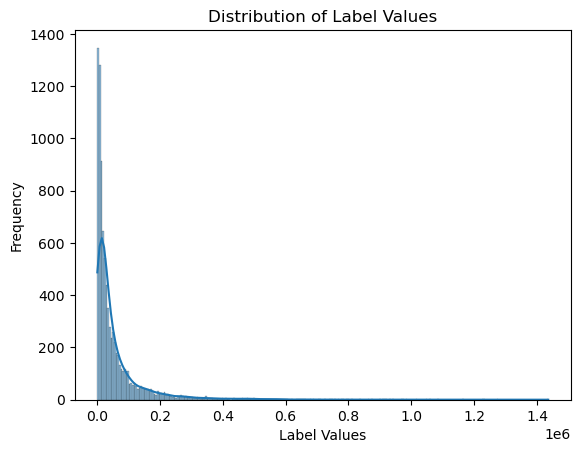

In [7]:
sns.histplot(df['label'], kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Label Values')
plt.show()

The distribution of the label values appears to be heavily skewed to the right, indicating a right-skewed distribution. 
A large number of observations have low label values, with a steep peak close to zero. This indicates that the majority of the data points have values near the lower end of the range.

The distribution has a long tail extending towards the higher label values, which suggests that there are fewer instances with high values, but those values can be significantly larger than the mode of the distribution.

The presence of a long tail might indicate potential outliers or extreme values in the higher end of the label values. These outliers can potentially have a strong influence on the mean of the distribution and could affect the performance of certain machine learning models.

In [8]:
(df['label'] <= 0).any()

False

 Given that the label distribution is right-skewed, a common approach is to apply a logarithmic transformation to the target variable to reduce the skewness. The log transformation is effective for handling right-skewed data, as it can help to stabilize the variance and make the data more symmetric.

In [9]:
if (df['label'] <= 0).any():
    # Add a small constant to the label values to avoid log(0)
    df['log_label'] = np.log(df['label'] + 1)
else:
    # Directly apply log transformation
    df['log_label'] = np.log(df['label'])

df = df.drop(columns='label', axis=1)
df = df.rename(columns= {'log_label': 'label'})
df.head()

,bili,sps,hrt,avtisst,hday,aps,bun,slos,scoma,label
0,0.000000,0.701343,0.152174,0.024,0.000000,0.138462,0.229508,0.02,0.000000,9.181426
1,0.093430,1.000000,0.619565,0.552,0.111111,0.969231,0.229508,0.00,0.721311,10.448599
2,0.249982,0.236132,0.358696,0.168,0.166667,0.523077,0.229508,0.26,0.000000,10.623617
3,0.093430,0.222162,0.358696,0.024,0.000000,0.123077,0.229508,0.00,0.000000,8.031060
4,0.093430,0.340296,0.619565,0.304,0.111111,0.292308,0.229508,0.24,0.426230,10.822315


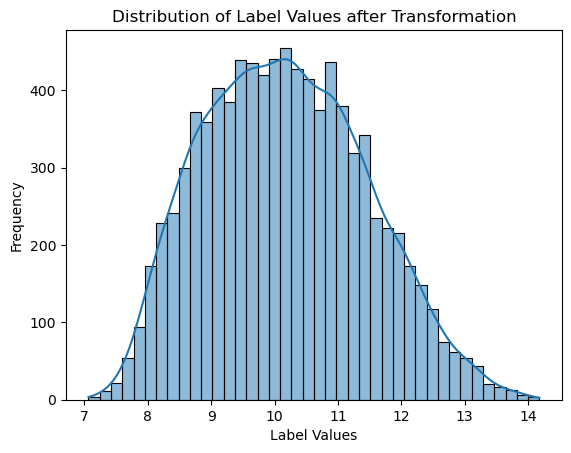

In [10]:
sns.histplot(df['label'], kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Label Values after Transformation')
plt.show()

## Linear Regression

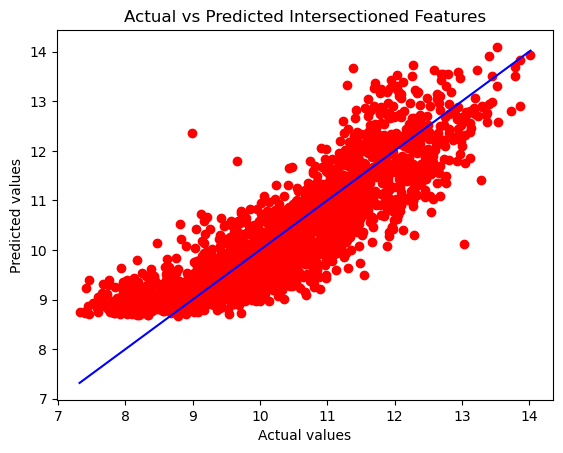

Coefficients:
 [0.19712023 0.19200083 0.04525576 1.47691475 1.09314465 0.11815657
 0.18199773 2.41291703 0.07243718]
Mean squared error: 0.36
Mean absolute error: 0.47
Root mean squared error: 0.60
Coefficient of determination: 0.78


In [11]:
"""Linear regression with Intersect Features"""
X = df.drop(['label'], axis=1)  # Drop non-feature columns
y = df['label']  # Use the log-transformed label



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the scaler to the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Predictions can be made with the model using the scaled test data
y_pred_reg = reg.predict(X_test_scaled)

# Scatter plot for actual vs predicted values
plt.scatter(y_test, y_pred_reg, color='red')
plt.title('Actual vs Predicted Intersectioned Features')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue')  # A reference line
plt.show()


# The coefficients
print('Coefficients:\n', reg.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_reg))

# The mean absolute error
print('Mean absolute error: %.2f' % mean_absolute_error(y_test, y_pred_reg))

# The root mean squared error
print('Root mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_reg)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_reg))




Want to improve results by using 

## Gradient Boosting Regressor with parametrs from GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Separate the features and the target variable
y= df['label']
X= df.drop(['label'], axis=1)  # Drop non-feature columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#define the model
GBR = GradientBoostingRegressor(random_state=42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=-1, verbose = 1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=4,
                          n_estimators=300, random_state=42, subsample=0.8)

 The best score across ALL searched params:
 0.86437300085031

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300, 'subsample': 0.8}


SearchGrid took 3 minutes to run

Saving it here for time economy:  
The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300, 'subsample': 0.8}

Now fitting parametrs to our model

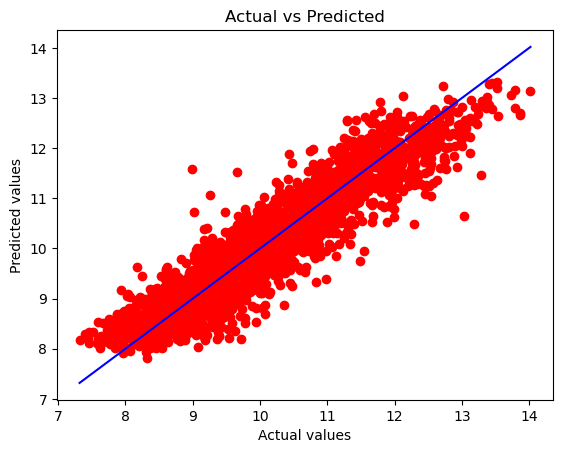

In [13]:
best_params = grid_GBR.best_params_

# Separate the features and the target variable
y= df['label']
X= df.drop(['label'], axis=1)  # Drop non-feature columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the scaler to the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Linear Regression model
gbdr = GradientBoostingRegressor(**best_params)
gbdr.fit(X_train_scaled, y_train)

# Predictions can be made with the model using the scaled test data
y_pred_gbdr = gbdr.predict(X_test_scaled)

# Scatter plot for actual vs predicted values
plt.scatter(y_test, y_pred_gbdr, color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue')  # A reference line
plt.show()

In [27]:

# The mean squared error
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_gbdr))

# The mean absolute error
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_gbdr))

# The root mean squared error
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_gbdr)))

# The coefficient of determination: 1 is perfect prediction
print('R^2: %.2f' % r2_score(y_test, y_pred_gbdr))

MSE: 0.22
MAE: 0.36
RMSE: 0.47
R^2: 0.87


Much better results! MSE, MAE and RMSE is much lower then result of simple Linear Regression and R^2 got higher from 78% to 87% showing better fit of the data.

## DecisionTree Regression

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, None],  # None means no maximum depth limit
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

# Create a base model
dt = DecisionTreeRegressor()

# Create a scorer for mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring=mse_scorer, cv=3, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best estimator
best_estimator = grid_search.best_estimator_

# Evaluate the best model
predictions = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error of the best model: {mse}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'criterion': 'poisson', 'max_depth': 7, 'min_samples_leaf': 8}
Mean Squared Error of the best model: 0.2936552348840871


In [22]:
from sklearn.metrics import mean_squared_error, r2_score

def train_test_DT_regression(X_train, X_test, y_train, y_test, leaf, depth, crit):
    """
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node 
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split.
    """
    # Create the DecisionTreeRegressor model object with specified parameters
    model = DecisionTreeRegressor(criterion=crit, max_depth=depth, min_samples_leaf=leaf)

    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred_dt = model.predict(X_test)

    # Compute the Mean Squared Error
    mse_score = mean_squared_error(y_test, y_pred_dt)

    # Compute the Root Mean Squared Error
    rmse_score = mean_squared_error(y_test, y_pred_dt, squared=False)

    # Compute the R-squared score
    r2_score_value = r2_score(y_test, y_pred_dt)
    
    return mse_score, rmse_score, r2_score_value, y_pred_dt


best_params = grid_search.best_params_

# Call the function with the best parameters from the grid search
mse, rmse, r2, y_pred_dt = train_test_DT_regression(
    X_train, X_test, y_train, y_test, 
    leaf=best_params['min_samples_leaf'], 
    depth=best_params['max_depth'], 
    crit=best_params['criterion']
)

print(f'Best Model - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}')


Best Model - MSE: 0.29365523488408707, RMSE: 0.5418996538881411, R-squared: 0.8209579753579237


Decision Tree is not as good as Gradient Boosting Regressor

Ensemble Model Metrics:
Mean Squared Error (MSE): 0.22
Mean Absolute Error (MAE): 0.37
R-squared (R2): 0.87


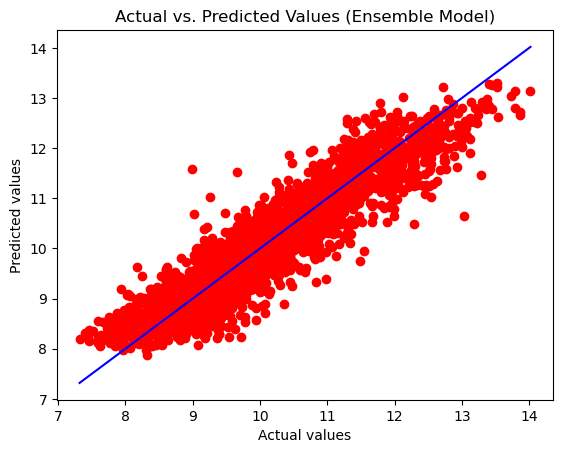

In [25]:

# Create a new DataFrame with predictions
ensemble_df = pd.DataFrame({
    'LinearRegression': y_pred_reg,
    'GradientBoosting': y_pred_gbdr,
    'DecisionTree': y_pred_dt
})

# Train a meta-model (e.g., another linear regression model)
# It is used in ensemble learning to combine the predictions of multiple base models to improve overall predictive performance
meta_model = LinearRegression()
meta_model.fit(ensemble_df, y_test)

# Use the meta-model to make predictions on new data
ensemble_predictions = meta_model.predict(ensemble_df)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

print("Ensemble Model Metrics:")
print(f"Mean Squared Error (MSE): {ensemble_mse:.2f}")
print(f"Mean Absolute Error (MAE): {ensemble_mae:.2f}")
print(f"R-squared (R2): {ensemble_r2:.2f}")


# Visualize the actual vs. predicted values for the ensemble model
plt.scatter(y_test, ensemble_predictions, color='red')
plt.title('Actual vs. Predicted Values (Ensemble Model)')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue')  # A reference line
plt.show()